In [3]:
import imageio
import gymnasium as gym
import numpy as np
import mediapy as media
import torch
# from act.policy import ACTPolicy
import gym_lite6.env, gym_lite6.scripted_policy
import mujoco

pygame 2.2.0 (SDL 2.30.2, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
scene_path = "models/cube_pickup.xml"
model = mujoco.MjModel.from_xml_path(scene_path)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)


""

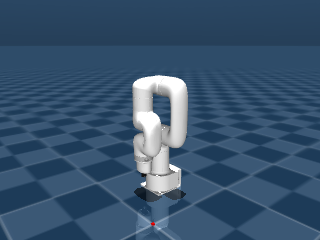

In [3]:

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.2
camera.elevation = -15
camera.azimuth = -130
camera.lookat = (0, 0, 0.3)

mujoco.mj_forward(model, data)

renderer.update_scene(data, camera)
media.show_image(renderer.render())


In [4]:
DURATION = 4          # seconds
FRAMERATE = 60        # Hz
frames = []
x0 = np.array([1.546, 0.541, 1.49 , 2.961, 0.596, 0.203])
mujoco.mj_resetData(model, data)
qpos = x0
data.qpos[:6] = qpos

while data.time < DURATION:
  # Move the target
  # pos, quat = pose(data.time, speed=1)

  data.ctrl[:6] = qpos
  # print(data.qpos)

  # data.qpos = 0.001
  if data.time < DURATION / 2:
    data.ctrl[6] = 30
  else:
    data.ctrl[6] = -30

  # mujoco.mj_camlight(model, data)
  mujoco.mj_step(model, data)
  # print(data.qfrc_actuator, data.qfrc_applied)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera)
    frames.append(renderer.render())
  
  qpos[0] -= 0.001

media.show_video(frames, loop=False)

In [5]:
class PickupTask(object):
    def __init__(self, l_gripper_name, r_gripper_name, box_name, floor_name) -> None:
        """
        geom ids
        """
        self.l_gripper_name = l_gripper_name
        self.r_gripper_name = r_gripper_name
        self.box_name = box_name
        self.floor_name = floor_name
        self.max_reward = 5
    
    def get_reward(self, model, data):
        """
        1 - close to box and not touching ground
        2 - one gripper touching box and not touching ground
        3 - two grippers touching box and not touching ground
        4 - two grippers touching box and box not touching ground
        5 - two grippers touching box and box > 0.2 in z
        """

        l_gripper_touching_ground = False
        r_gripper_touching_ground = False
        box_touching_ground = False
        l_gripper_touching_box = False
        r_gripper_touching_box = False

        for geom in data.contact.geom:
            if all(np.isin(geom, [model.geom(self.floor_name).id, model.geom(self.l_gripper_name).id])):
              l_gripper_touching_ground = True
            
            if all(np.isin(geom, [model.geom(self.floor_name).id, model.geom(self.r_gripper_name).id])):
              r_gripper_touching_ground = True
                        
            if all(np.isin(geom, [model.geom(self.floor_name).id, model.geom(self.box_name).id])):
              box_touching_ground = True
            

            if all(np.isin(geom, [model.geom(self.box_name).id, model.geom(self.l_gripper_name).id])):
              l_gripper_touching_box = True
            if all(np.isin(geom, [model.geom(self.box_name).id,  model.geom(self.r_gripper_name).id])):
              r_gripper_touching_box = True
        
        gripper_touching_ground = l_gripper_touching_ground or r_gripper_touching_ground
        close_to_box = np.linalg.norm(data.body(self.l_gripper_name).xpos - data.body(self.box_name).xpos) < 0.07
        box_above_height = data.body(self.box_name).xpos[2] > 0.2

        # print(f"gripper_touching_ground: {gripper_touching_ground}, box_touching_ground: {box_touching_ground}, l_gripper_touching_box: {l_gripper_touching_box}, r_gripper_touching_box: {r_gripper_touching_box}, close_to_box: {close_to_box}, box_above_height: {box_above_height}")

        reward = 0
        if l_gripper_touching_box and r_gripper_touching_box and box_above_height:
            assert(not box_touching_ground)
            assert(not gripper_touching_ground)
            assert(close_to_box)
            reward = 5
        elif l_gripper_touching_box and r_gripper_touching_box and not box_touching_ground and not gripper_touching_ground:
            assert(close_to_box)
            reward = 4
        elif l_gripper_touching_box and r_gripper_touching_box and not gripper_touching_ground:
            assert(close_to_box)
            reward = 3
        elif l_gripper_touching_box or r_gripper_touching_box and not gripper_touching_ground:
            assert(close_to_box)
            reward = 2
        elif close_to_box and not gripper_touching_ground:
            reward = 1
        
        return reward
  
task = PickupTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')

camera.distance = 0.5
camera.elevation = -10
# camera.azimuth = -130
camera.lookat = (0.1, 0.1, 0)

voption = mujoco.MjvOption()
voption.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = False
voption.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

f = []
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
assert reward == 0, f"Reward is {reward}, contacts: {data.contact}"

# Gripper touching ground near cube
data.qpos = np.array([0.57, 1.04, 1.2, -0.00014, 0.00034, 5.1e-05, -0.0086, 0.0083, 0.3, 0.22, 0.005, 0.65, -0.65, 0.28, -0.28])
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
assert reward == 0, f"Reward is {reward}, contacts: {data.contact}"

# Close to box
data.qpos = np.array([0.75, 0.73, 0.96, -0.00021, 0.00023, -1.4e-06, -0.0095, 0.0086, 0.2, 0.2, 0.01, 1, -1.7e-06, 1.8e-06, -0.0023])
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
assert reward == 1, f"Reward is {reward}, contacts: {data.contact}"

# One gripper touching box
data.qpos = np.array([0.75, 0.86, 0.97, -0.00027, 0.0029, -0.00015, -0.0096, 0.0087, 0.2, 0.2, 0.01, 1, -3.5e-05, -6.1e-05, -0.0039])
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
assert reward == 2, f"Reward is {reward}, contacts: {data.contact}"

# Two grippers touching box but also touching ground
data.qpos = np.array([0.82, 0.981, 1.1, -0.00012, -1.6e-05, 1.6e-05, -0.0066, 0.0085, 0.2, 0.21, 0.005, 0.71, -0.71, 0.052, -0.052])
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
assert reward == 0, f"Reward is {reward}, contacts: {data.contact.geom}"

## Seems to be an issue with feeding qpos in and getting contact with both grippers

# Two grippers touching box and box on ground
data.qpos = np.array([0.63, 1.19, 1.6, -0.0004, 0.39, -5.6e-07, -0.0049, 0.0051, 0.3, 0.21, 0.005, 0.63, -0.63, 0.32, -0.32])
# data.ctrl = np.array([0.63, 1.2, 1.7, 0, 0.39, 0, 1.5])
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
media.show_images(f)
assert reward == 3, f"Reward is {reward}, contacts: {data.contact.geom}"

# data.qpos = np.array([0.82, 1, 1.2, -0.00022, 0.00026, -4.4e-06, -0.0043, 0.0062, 0.22, 0.23, 0.013, 0.69, -0.65, 0.21, -0.23])
# mujoco.mj_forward(model, data)
# renderer.update_scene(data, camera, voption); f.append(renderer.render())
# reward = task.get_reward(model, data)
# assert reward == 4, f"Reward is {reward}, contacts: {data.contact}"

# # Lifted
# data.qpos = np.array([0.82, 0.42, 1.2, -0.00068, 0.00086, -1.4e-06, -0.004, 0.006, 0.27, 0.29, 0.23, 0.82, -0.44, 0.17, -0.32])
# mujoco.mj_forward(model, data)
# camera.lookat = (0.1, 0.1, 0.2)
# renderer.update_scene(data, camera, voption); f.append(renderer.render())
# reward = task.get_reward(model, data)
# assert reward == 4, f"Reward is {reward}, contacts: {data.contact}"




NameError: name 'camera' is not defined

""

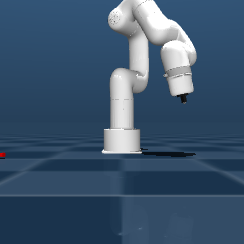

In [205]:
from importlib import reload

reload(gym_lite6.env)
reload(gym_lite6.utils)
reload(gym_lite6.scripted_policy)
env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=300,
)
observation, info = env.reset()
media.show_image(env.render(), width=400, height=400)


## Run a scripted rollout

In [51]:
# Run a scripted rollout

policy = gym_lite6.scripted_policy.ScriptedPickupPolicy(env, 'end_effector', 'box', 'gripper_left_finger', 'gripper_right_finger', max_vel=0.2)

# Reset the policy and environmens to prepare for rollout
policy.reset()
observation, info = env.reset(seed=69)

# Prepare to collect every rewards and all the frames of the episode,
# from initial state to final state.
# rewards = []
frames = []

# Render frame of the initial state
frames.append(env.render())


step = 0
done = False
while not done and len(frames) < 500:

    # Predict the next action with respect to the current observation
    action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)

    # Step through the environment and receive a new observation
    observation, reward, terminated, truncated, info = env.step(action)

    if (policy.stage == 4):
        truncated = True
    print(f"{step=} {reward=} {terminated=}")

    frames.append(env.render())

    # The rollout is considered done when the success state is reach (i.e. terminated is True),
    # or the maximum number of iterations is reached (i.e. truncated is True)
    done = terminated | truncated | done
    step += 1

if terminated:
    print("Success!")
else:
    print("Failure!")

media.show_video(frames, fps=env.metadata["render_fps"])

{0: {'start_time': 0.0, 'end_time': 3.5303569934337418, 'T_start': array([[ 0.79635198, -0.06000929, -0.60184916,  0.15714209],
       [-0.30852679, -0.89617369, -0.31887918, -0.13297725],
       [-0.52022567,  0.43962666, -0.73218417,  0.02696257],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.33306328],
       [ 0.        , -1.        ,  0.        ,  0.35340619],
       [ 0.        ,  0.        , -1.        ,  0.0235    ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.33306328, 0.35340619, 0.0235    ]), 'goal_quat': array([0, 1, 0, 0])}}
step=0 reward=0 terminated=False
step=1 reward=0 terminated=False
step=2 reward=0 terminated=False
step=3 reward=0 terminated=False
step=4 reward=0 terminated=False
step=5 reward=0 terminated=False
step=6 reward=0 terminated=False
step=7 reward=0 terminated=False
step=8 reward=0 terminated=False
step=9 reward=0 terminated=False
step=10 re

## Record scripted to h5py

In [52]:
import h5py
import os

def create_h5py_dataset(data_dict, group):
  for key, val in data_dict.items():
    if isinstance(val, dict):
      grp = group.create_group(key)
      create_h5py_dataset(data_dict[key], grp)
    elif isinstance(val, list):
      group.create_dataset(key, data=val)

def record_episodes(env, policy, dataset_dir, n=1, len=300):

  if not os.path.isdir(dataset_dir):
    os.makedirs(dataset_dir, exist_ok=True)

  successful_trajectories = 0

  while successful_trajectories < n:
    episode_idx = successful_trajectories
    print(f"Episode {episode_idx}")
    observation, info = env.reset()
    policy.reset()

    data = {"action": {"qpos": [], "gripper": []}, "observation": {"state": {"qpos": [], "gripper": []}, "pixels": []}, "reward": []}
    for step in range(len):
      action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)
      observation, reward, terminated, truncated, info = env.step(action)

      # action = {"qpos": step, "gripper": 0}
      # observation = {"qpos": step, "gripper": 1}
      # reward = 2
      # print(observation)
      # print(data)
      data["action"]["qpos"].append(action["qpos"])
      data["action"]["gripper"].append(action["gripper"])
      data["observation"]["state"]["qpos"].append(observation["state"]["qpos"])
      data["observation"]["state"]["gripper"].append(observation["state"]["gripper"])
      data["observation"]["pixels"].append(observation["pixels"])
      data["reward"].append(reward)
    
    if policy.stage == 4:
      path = dataset_dir + f"/ep_{episode_idx}"
      with h5py.File(path + ".hdf5", "w") as f:
        create_h5py_dataset(data, f)
      # out = cv2.VideoWriter(path + ".mp4", cv2.VideoWriter_fourcc(*'mp4v'), env.metadata["render_fps"], (w, h))
      media.write_video(path + ".mp4", data["observation"]["pixels"], fps=env.metadata["render_fps"])
      successful_trajectories += 1
      print(f"Success, saved {path}")
    else:
      print("Failed, retrying")

    media.show_video(data["observation"]["pixels"])

    

## Record to HF dataset

In [131]:
import lerobot.common.datasets.push_dataset_to_hub.utils
from datasets import Dataset, Features, Image, Sequence, Value
from lerobot.common.datasets.push_dataset_to_hub.utils import concatenate_episodes
from lerobot.common.datasets.utils import (
    hf_transform_to_torch,
)
import os
reload(lerobot.common.datasets.push_dataset_to_hub.utils)
import datetime

def record_episodes_to_hf(env, policy, dataset_dir, num_ep=1, num_frames=300):
  features = {}
  num_readings = num_ep*num_frames
  features["observation.pixels"] = Image()
  features["observation.state.qpos"] = Sequence(length=6, feature=Value(dtype="float32", id=None))
  features["observation.state.gripper"] = Value(dtype="int8", id=None)
  features["reward"] = Value(dtype="int8", id=None)
  features["action.qpos"] = Sequence(length=6, feature=Value(dtype="float32", id=None))
  features["action.gripper"] = Value(dtype="int8", id=None)
  features["episode_index"] = Value(dtype="int64", id=None)
  features["frame_index"] = Value(dtype="int64", id=None)
  features["timestamp"] = Value(dtype="float32", id=None)
  # features["next.done"] = Value(dtype="bool", id=None)
  features["index"] = Value(dtype="int64", id=None)

  ep_dicts = []

  if not os.path.isdir(dataset_dir):
    os.makedirs(dataset_dir, exist_ok=True)

  successful_trajectories = 0

  while successful_trajectories < num_ep:
    ep_idx = successful_trajectories
    print(f"Episode {ep_idx}")
    observation, info = env.reset()
    policy.reset()

    ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.gripper": [], "observation.pixels": [], "reward": [], "timestamp": [], "frame_index": [],}
    # ep_dict = {"observation.state.qpos": [], "frame_index": []}
    ep_dict["episode_index"] = [ep_idx] * num_frames

    for step in range(num_frames):
      action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)
      observation, reward, terminated, truncated, info = env.step(action)

      ep_dict["action.qpos"].append(action["qpos"])
      ep_dict["action.gripper"].append(action["gripper"])
      ep_dict["observation.state.qpos"].append(observation["state"]["qpos"])
      ep_dict["observation.state.gripper"].append(observation["state"]["gripper"])
      ep_dict["observation.pixels"].append(observation["pixels"])
      ep_dict["reward"].append(reward)
      ep_dict["timestamp"].append(env.unwrapped.data.time)
      ep_dict["frame_index"].append(step)
      # ep_dict["next.done"] = terminated | truncated
    
    if policy.stage == 4:
      
      for key in ep_dict:
        dtype = getattr(torch, features[key].feature.dtype) if 'feature' in features[key].__dict__ and features[key].feature.dtype in torch.__dict__ else None
        ep_dict[key] = torch.tensor(ep_dict[key], dtype=dtype)
      
      ep_dicts.append(ep_dict)
      successful_trajectories += 1
    else:
      print("Failed, retrying")

    # media.show_video(data["observation.pixels"])

  data_dict = concatenate_episodes(ep_dicts)
  # print(data_dict, features)
  hf_dataset = Dataset.from_dict(data_dict, features=Features(features))
  
  hf_dataset.save_to_disk(dataset_dir + f"/scripted_trajectories_{num_ep}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.hf")

  return hf_dataset


In [132]:
policy = gym_lite6.scripted_policy.ScriptedPickupPolicy(env, 'end_effector', 'box', 'gripper_left_finger', 'gripper_right_finger', max_vel=0.2)
# record_episodes(env, policy, "dataset/pickup_side_cam", n=50)
hf_dataset = record_episodes_to_hf(env, policy, "dataset/hf_test", num_ep=50)
hf_dataset.set_transform(hf_transform_to_torch)


Episode 0
{0: {'start_time': 0.0, 'end_time': 11.204637110835082, 'T_start': array([[-0.10034729, -0.76017988,  0.64191664,  0.21288729],
       [ 0.50746894, -0.59404935, -0.62416396, -0.22996481],
       [ 0.85580704,  0.26311959,  0.44537892,  0.47810851],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.11294365],
       [ 0.        , -1.        ,  0.        ,  0.30963135],
       [ 0.        ,  0.        , -1.        ,  0.0235    ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.11294365, 0.30963135, 0.0235    ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying
Episode 0
{0: {'start_time': 0.0, 'end_time': 2.3149105653313553, 'T_start': array([[ 0.66357123, -0.74648505, -0.04932845,  0.05841085],
       [-0.74573001, -0.65475915, -0.12319583, -0.08351049],
       [ 0.05966559,  0.11853491, -0.99115564,  0.06693423],
       [ 0.        ,  0.        ,  0.        ,  1.   

Saving the dataset (0/1 shards):   0%|          | 0/15000 [00:00<?, ? examples/s]

## Create the MLP Policy

In [223]:
import torchvision


class MLPPolicy(torch.nn.Module):
  def __init__(self, hidden_layer_dims, state_dims=8):
    """
    state_dims: 6 for arm, 2 for gripper
    """
    super().__init__()

    # self.img_feature_extractor = torchvision.models.detection.backbone_utils.resnet_fpn_backbone('resnet18', )
    
    self.img_feature_extractor = self._create_img_feature_extractor()
    # Resnet output is 1x512, 2 bits for gripper
    self.actor = self._create_actor(512 + state_dims, hidden_layer_dims, state_dims)

    self.sigmoid = torch.nn.Sigmoid()
  
  def _create_actor(self, input_size, hidden_layer_dims, output_size):
    actor = []
    actor.append(torch.nn.Linear(input_size, hidden_layer_dims[0]))
    actor.append(torch.nn.ReLU())
    for i in range(len(hidden_layer_dims) - 1):
      actor.append(torch.nn.Linear(hidden_layer_dims[i], hidden_layer_dims[i+1]))
      actor.append(torch.nn.ReLU())
    actor.append(torch.nn.Linear(hidden_layer_dims[-1], output_size))
    return torch.nn.Sequential(*actor)

  def _create_img_feature_extractor(self):
    """
    ResNet18 backbone with last fc layer chopped off
    Weights frozen
    Ouput shape [1, 512, 1, 1]
    """
    resnet = torchvision.models.resnet18(pretrained=True)
    modules = list(resnet.children())[:-1]
    backbone = torch.nn.Sequential(*modules)
    backbone.requires_grad_(False)
    return backbone

  def forward(self, state, image):
    img_features = torch.squeeze(self.img_feature_extractor(image), dim=[2, 3])
    input = torch.hstack((state, img_features))
    out = self.actor(input)
    # Gripper sigmoid
    out[:, 6:8] = self.sigmoid(out[:, 6:8])
    return out

  
  def predict(self, state, image, episode_start=None, deterministic=None):
    return self.forward(state, image)
  

  # def __init__(self, args_override):
  #       super().__init__()
  #       model, optimizer = build_CNNMLP_model_and_optimizer(args_override)
  #       self.model = model # decoder
  #       self.optimizer = optimizer

  #   def __call__(self, qpos, image, actions=None, is_pad=None):
  #       env_state = None # TODO
  #       normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
  #                                        std=[0.229, 0.224, 0.225])
  #       image = normalize(image)
  #       if actions is not None: # training time
  #           actions = actions[:, 0]
  #           a_hat = self.model(qpos, image, env_state, actions)
  #           mse = F.mse_loss(actions, a_hat)
  #           loss_dict = dict()
  #           loss_dict['mse'] = mse
  #           loss_dict['loss'] = loss_dict['mse']
  #           return loss_dict
  #       else: # inference time
  #           a_hat = self.model(qpos, image, env_state) # no action, sample from prior
  #           return a_hat

## Test the untrained policy

In [134]:
def encode_gripper(gripper):
  return {-1: [0, 1], 0: [0, 0], 1: [1, 0]}[gripper]

def decode_gripper(gripper):
  gripper = np.round(gripper).tolist()
  out = 0
  if gripper == [0, 0]:
      out = 0
  elif gripper == [0, 1]:
      out = -1
  elif gripper == [1, 0]:
      out = 1
  else:
      ValueError("Not a valid gripper encoding")
  return out


In [224]:
device = torch.device("mps")

policy = MLPPolicy([100, 100]).to(device)

/Users/Eugene/miniconda3/envs/lerobot/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Eugene/miniconda3/envs/lerobot/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [229]:
# Reset the policy and environmens to prepare for rollout
def evaluate_policy(policy, env, n, visualise=False):
  avg_reward = 0
  for i in range(n):
    numpy_observation, info = env.reset()

    # Prepare to collect every rewards and all the frames of the episode,
    # from initial state to final state.
    rewards = []
    frames = []
    action = {}

    # Render frame of the initial state
    frames.append(env.render())

    step = 0
    done = False
    while not done and len(frames) < 300:
      # Prepare observation for the policy running in Pytorch
      # Get qpos in range (-1, 1), gripper is already in range (-1, 1)
      qpos_normalised = np.squeeze(env.unwrapped.normalize_qpos(numpy_observation["state"]["qpos"]))
      gripper = encode_gripper(numpy_observation["state"]["gripper"])
      state = torch.from_numpy(np.hstack((qpos_normalised, gripper)))
      image = torch.from_numpy(numpy_observation["pixels"])
      
      # Convert to float32 with image from channel first in [0,255]
      # to channel last in [0,1]
      state = state.to(torch.float32)
      image = image.to(torch.float32) / 255
      image = image.permute(2, 0, 1)

      # Add extra (empty) batch dimension, required to forward the policy
      state = state.unsqueeze(0)
      image = image.unsqueeze(0)

      # Send data tensors from CPU to GPU
      state = state.to(device, non_blocking=True)
      image = image.to(device, non_blocking=True)

      # Predict the next action with respect to the current observation
      with torch.inference_mode():
          raw_action = policy.predict(state, image).flatten().to("cpu")

      action["qpos"] = env.unwrapped.unnormalize_qpos(raw_action[:6].numpy())
      action["gripper"] = decode_gripper(raw_action[6:8].numpy())
      # print(action)
      # numpy_action = np.hstack((action["qpos"], action["gripper"]))

      # Step through the environment and receive a new observation
      numpy_observation, reward, terminated, truncated, info = env.step(action)
      # Keep track of all the rewards and frames
      rewards.append(reward)
      frames.append(env.render())

      # The rollout is considered done when the success state is reach (i.e. terminated is True),
      # or the maximum number of iterations is reached (i.e. truncated is True)
      done = terminated | truncated | done
      step += 1
    
    avg_reward += rewards[-1]/n

    if visualise:
      media.show_video(frames, fps=env.metadata["render_fps"])
    
  return avg_reward, frames

In [230]:
evaluate_policy(policy, env, 1, visualise=True)[0]

0.0

## Train

In [198]:
def preprocess_function(batch):
    """
    Take a batch of data and put it in a suitable tensor format for the model
    """
    observation_qpos_normalised = env.unwrapped.normalize_qpos(batch["observation.state.qpos"]).to(torch.float32)
    observation_gripper = torch.tensor([encode_gripper(x.item()) for x in batch["observation.state.gripper"]], dtype=torch.float32)
    
    observation_state = torch.hstack((observation_qpos_normalised, observation_gripper))

    action_qpos_normalised = env.unwrapped.normalize_qpos(batch["action.qpos"]).to(torch.float32)
    action_gripper = torch.tensor([encode_gripper(x.item()) for x in batch["action.gripper"]], dtype=torch.float32)
    action_state = torch.hstack((action_qpos_normalised, action_gripper))
    
    # Convert to float32 with image from channel first in [0,255]
    # to channel last in [0,1]
    image = batch["observation.pixels"].to(torch.float32) / 255

    batch = {"preprocessed.observation.state": observation_state, "preprocessed.observation.image": image,
             "preprocessed.action.state": action_state}
    return batch

In [199]:
from datasets import load_from_disk
from torch.utils.data import DataLoader

# def collate_fn(batch):
#     return {
#         "obs": torch.Tensor([x["obs"] for x in batch]),
#         "acts": torch.Tensor([x["acts"] for x in batch]).to(torch.long) # long needed for one hot encoding
#     }

dataset = load_from_disk("dataset/hf_test/scripted_trajectories_50_2024-07-14_14-25-22.hf").with_format("torch")
print("Preprocessing dataset")
dataset = dataset.map(preprocess_function, batched=True)
print("Done preprocessing")

dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()


Preprocessing dataset


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Done preprocessing


In [245]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="./runs/lite6_pick_place")

n_epoch = 5
step = 0
for epoch in range(n_epoch):
  for batch in tqdm(dataloader):

    # Send data tensors from CPU to GPU
    state = batch["preprocessed.observation.state"].to(device, non_blocking=True)
    image = batch["preprocessed.observation.image"].to(device, non_blocking=True)
    a_pred = policy.predict(state, image)
    a_hat = batch["preprocessed.action.state"].to(device, non_blocking=True)

    loss = loss_fn(a_pred, a_hat)
    writer.add_scalar("Loss/train", loss, step)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    step += 1
  
  print(f"Epoch: {epoch+1}/{n_epoch}, steps: {step}, loss: {loss.item()}")
  # Show evaluation
  avg_reward, frames = evaluate_policy(policy, env, 5, visualise=False)
  media.show_video(frames)
  print("avg reward: ", avg_reward)
  writer.add_scalar("Reward/val", avg_reward, step)
  # _, frames = evaluate_policy(policy, env, 1, visualise=True)
  writer.add_images("Image", np.stack([frames[x].transpose(2, 0, 1) for x in range(0, len(frames), 50)], axis=0), step)
  
writer.flush()

writer.close()


  0%|                                | 0/59 [01:00<?, ?it/s]


Epoch: 1/5, steps: 1, loss: 1.0800750255584717


avg reward:  0.0


  0%|                                | 0/59 [00:05<?, ?it/s]


Epoch: 2/5, steps: 2, loss: 1.0923511981964111


avg reward:  0.0


  0%|                                | 0/59 [00:04<?, ?it/s]


Epoch: 3/5, steps: 3, loss: 1.0950207710266113


avg reward:  0.0


  0%|                                | 0/59 [00:04<?, ?it/s]


Epoch: 4/5, steps: 4, loss: 0.9999403953552246


avg reward:  0.0


  0%|                                | 0/59 [00:05<?, ?it/s]


Epoch: 5/5, steps: 5, loss: 0.8836615085601807


In [244]:
np.stack([frames[x].transpose(2, 0, 1) for x in range(0, len(frames), 50)], axis=0).shape

(6, 3, 244, 244)